# Linear Stability:QG Stratified Jet Model #

Here will compute the linear stability for the stratified Quasi-geostrophic model.  
One of the aims is to reproduce some of the results from Flierl et al. (1987), Journal of Physical Oceanography, 17, pp 1408-1438 [doi: http://dx.doi.org/10.1175/1520-0485(1987)0172.0.CO] but extend it to the stratifeid regime.

## Basic State
Assume that we have an exact steady solution to the reducd gravity Quasi-geostrophic (QG) model that only depends
on the meridional coordiante.  We define the streamfunction, velocity and Potential Vorticity to be,
$$
\psi = \Psi(y,z), \quad\quad
u = U(y,z) = - \partial_y \Psi, \quad \quad
q = Q(y,z) = \left( \partial_{yy} + \frac{N^2}{f_0^2} \partial_{zz} \right)\Psi
$$
We use the convention that captial letters are for the basic state.

## Perturbation
Next we assume that we have small amplitude perturbations that can depend on either spatial coordiante and time,
$$
\psi(x,y,z,t), \quad\quad
u(x,y,z,t), \quad\quad
q(x,y,z,t).
$$
If we substitute a perturbated basic state,
$$
\psi = \Psi + \psi,
$$
into the governing nonlinear equations, the smallness of the perturbations allows us to neglect the nonlinear terms.  Physically, that means we neglect the advection of the perturbation by the pertubation but still maintain the advection of the pertrubation by the mean state and the advection of the mean state by the perturbation.

## Linearized Equations
The linearized governing equation are
$$
\partial_t q + J(\Psi, q) + J(\psi, Q + \beta) = 0,
$$
which we can rewrite as,
$$
\partial_t q + U \partial_x q + (\partial_y Q + \beta) \partial_x \psi = 0.
$$

## Modal Decompositon
Since the domain is assumed to be periodic in the zonal direction and we are looking for wave-like solutions, we assume that the perturbation can be decomposed as,
$$
\psi = \widehat{\psi} \exp[i (k x - \omega t)]
$$
If we substitute this into our linear equation, use our equation for PV and then dividing by the exponential multiplied by $i k$, we obtain,
$$
 \frac{\omega}{k} \left( \partial_{yy} + \partial_{zz} - k^2 \right) \widehat{\psi}  
 = U (\partial_{yy} + \partial_{zz} - k^2) \widehat{\psi} + (\beta + \partial_y Q )\widehat{\psi} , 
$$
where we rewrite the gradient of the PV of the basic state in terms of the velocity itself.

## Numerical Approach
This is a generalized differential eigenvalue problem where the eigenvalue is the phase speed, $\omega/k$, and the eigenvector determines the spatial structure.  For a general velocity field it is impossible to find an analytical solution to this problem.  However, if we discretize the meridional domain and then approximate the differential operators with algebraic operators, we then obtain an algebraic eigenvalue problem that is much easier to solve. 

There are a variety of different ways to approximate the derivatives.  The most straight forward is to use a second order centre differencing scheme.  This is adequate for many problems but only second order accurate.  A method that is usually far better is to use a spectral method.  Since our perturbation need not be periodic in the meridional direction, it is perhaps best to use a Chebyschev grid in $y$.  Reference Trefethen.

## Differential Operators
If we define $L$ to be the length in the $y$ direction and $N$ is the number of points in that direction, then a second-order Finite Difference operator can be built as follows:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys

from firedrake import *
from firedrake.petsc import PETSc
try:
    from slepc4py import SLEPc
except ImportError:
    import sys
    warning("Unable to import SLEPc, eigenvalue computation not possible (try firedrake-update --slepc)")
    sys.exit(0)

# Define Parametres

Ly   = 10.0
Lz   = 20.0*1./2
Uj   = 0.5
ny   = 50
nz   = ny
dz   = Lz/nz

# Define parameters

beta = Constant('0.0')
Bui2 = Constant('1.0')

method = 'FD2'
#profile = 'gaussian'
profile = 'bickley'
#profile = 'bump'

In [3]:
# Define Integral than Extrude Mesh

mesh = RectangleMesh(ny, nz, Ly, Lz)
x    = SpatialCoordinate(mesh)

# Order of the solution

p = 0

# Define CG function space

V  = FunctionSpace(mesh,'CG',p+2)

# Impose zero Dirichlet Boundary Conditions

bc = [DirichletBC(V, 0.0, 1),
      DirichletBC(V, 0.0, 2)]

In [4]:
# Background State
if profile == 'bickley':

    Ub  = Function(V).interpolate(Uj/pow(cosh(x[0]-Ly/2),2))
    dUb = Function(V).interpolate(-((2.)*Uj)/pow(cosh(x[0]-Ly/2),2)*tanh(x[0]-Ly/2))
    dQb = Function(V).interpolate(4.0*Uj*(0.5 - pow(sinh(x[0]-Ly/2),2))/pow(cosh(x[0]-Ly/2),4))

    #U  = Uj/pow(np.cosh(x[0]-Ly/2),2)
    #Qy = 4.0*Uj*(0.5 - pow(np.sinh(x[0]-Ly/2),2))/pow(np.cosh(x[0]-Ly/2),4)
    
#elif profile == 'gaussian':
    
#    U = Uj*np.exp(-(x[0]-Ly/2)**2)
#    Qy = -2.*Uj*np.exp(-(x[0]-Ly/2)**2)*(2.*(x[0]-Ly/2)**2 - 1.)
    
#elif profile == 'bump':
    
#    step = np.piecewise(y, [np.abs(x[0] - Ly/2) < 1, np.abs(x[0] - Ly/2) >= 1], [1.0, 0])
#    U  = step*np.exp(-1./(1. -(x[0]-Ly/2)**2))
#    Qy = step*-2.*np.exp(-1./(1. -(x[0]-Ly/2)**2))*(3.*(x[0]-Ly/2.)**4 - 1)/((x[0]-Ly/2.)**2-1)**4
#    U[np.isinf(U)] = 0.
#    Qy[np.isinf(Qy)] = 0.
#    U[np.isnan(U)] = 0.
#    Qy[np.isnan(Qy)] = 0.

else:
    
    print("profile must be bickley, gaussian or bump")
    sys.exit()
    
#plt.plot(mesh, Ub)
#plt.show()
#plt.plot(y,Qy)
#plt.show()

In [5]:
num_eigenvalues = 40

# Define modes 

emodes_real, emodes_imag = Function(V), Function(V)

# Define test and trial functions

phi, psi = TestFunction(V), TrialFunction(V)

In [6]:
# Define range of wavenumbers 
dk = 2.5e-2
#kk = np.arange(1. - dk,1.,dk)
kk = np.arange(dk,2.,dk)
#kk = kk[49:50]
Nk = len(kk)

egs_re  = np.zeros((len(kk),num_eigenvalues))
egs_im  = np.zeros((len(kk),num_eigenvalues))

In [ ]:
emodes_real, emodes_imag = Function(V), Function(V)

cnt = 0
for k in kk:

    k2   = Constant(k**2)

    # Define Weak form

    a = ( inner(grad(Ub*phi), grad(psi)) + (k2*Ub - dQb)*phi*psi )*dx
    m = ( inner(grad(phi),grad(psi)) + k2*phi*psi )*dx

    petsc_a = assemble(a).M.handle
    petsc_m = assemble(m, bcs=bc).M.handle

    # Define Petsc options

    opts = PETSc.Options()
    opts.setValue("eps_gen_non_hermitian", None)
    opts.setValue("st_pc_factor_shift_type", "NONZERO")
    opts.setValue("eps_type", "krylovschur")
    opts.setValue("eps_largest_imaginary", None)
    opts.setValue("eps_tol", 1e-10)

    # Define Solver options

    es = SLEPc.EPS().create(comm=COMM_WORLD)
    es.setDimensions(num_eigenvalues)
    es.setOperators(petsc_a, petsc_m)
    es.setFromOptions()
    es.solve()

    # Additionally we can find the number of converged eigenvalues. ::

    nconv = es.getConverged()
    imax = min(nconv, num_eigenvalues)
    for i in range(imax):
        vr, vi = petsc_a.getVecs()

        lam = es.getEigenpair(i, vr, vi)
        
        egs_re[cnt,i] = k*lam.real
        egs_im[cnt,i] = k*lam.imag
    
        # Get eigenvectors for last loop (fix)
        emodes_real.vector()[:], emodes_imag.vector()[:] = vr, vi

        # Plot real part

        #p = plot(emodes_real)
        #plt.xlim([0,Ly])
        #plt.ylim([0,Lz])
        #plt.show()

        # Plot imaginary part
        #p = plot(emodes_imag)
        #plt.xlim([0,Ly])
        #plt.ylim([0,Lz])
        #plt.show()

    #print(k, egs_im[cnt,0], egs_im[cnt,2])
    # Find eigenfunctions
    #emodes_real.vector()[:], emodes_imag.vector()[:] = vr, vi
    #print "Leading eigenvalue is:", lam, " for cnt = ", cnt, " with nconv = ", nconv
    cnt += 1


0.025 0.00308252544217 0.0028611247162
0.05 0.00617663780722 0.00571613502985
0.075 0.00929180148143 0.00855891191852
0.1 0.0124336519701 0.0113833297769
0.125 0.0156029950304 0.0141832594133
0.15 0.0187956027387 0.0169525776593
0.175 0.0220027077387 0.0196851844107
0.2 0.0252119742173 0.0223750270243
0.225 0.0284086882247 0.025016131173
0.25 0.0315769440195 0.028743782976
0.275 0.0347006737885 0.0327162829353
0.3 0.0377644440029 0.0365810189266
0.325 0.040754003152 0.0403097981774
0.35 0.0438837623219 0.0436566054003
0.375 0.0472909282662 0.0464611542254
0.4 0.0505242426768 0.0491582146715
0.425 0.0535801084528 0.0517399384898
0.45 0.0564573048584 0.0541999379819
0.475 0.0591562163559 0.0565331350605
0.5 0.0616782932904 0.0587356036622
0.525 0.064025681173 0.0608044169449
0.55 0.0662009694923 0.0627375057635
0.575 0.0682070235126 0.064533531556
0.6 0.0700468726963 0.0661917746406
0.625 0.0717236372284 0.0677120377041
0.65 0.073240479964 0.0690945636875
0.675 0.0746005753777 0.07033996

0.0811259455243 0.0
Profile =  bickley
Ny   =  50
Nz   =  50


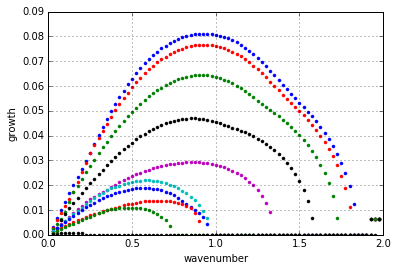

In [87]:
plt.clf
plt.plot(kk,egs_im[:,0],'.b')
plt.plot(kk,egs_im[:,2],'.r')
plt.plot(kk,egs_im[:,4],'.g')
plt.plot(kk,egs_im[:,6],'.k')
plt.plot(kk,egs_im[:,8],'.m')
plt.plot(kk,egs_im[:,10],'.c')
plt.plot(kk,egs_im[:,12],'.b')
plt.plot(kk,egs_im[:,14],'.r')
plt.plot(kk,egs_im[:,16],'.g')
plt.plot(kk,egs_im[:,18],'.k')
plt.grid('on')
#plt.title('Bump Jet')
plt.xlabel('wavenumber')
plt.ylabel('growth')
print np.max(egs_im[:,0]), np.max(egs_im[:,1])
#plt.xlim([0,2])
#plt.savefig("figure_bump.png") #
#plt.savefig("growth_Bickley.png") 

print "Profile = ", profile
print "Ny   = ", ny
print "Nz   = ", nz
plt.show()

0.0810853150603 0.0
Profile =  bickley
Ny   =  50
Nz   =  50


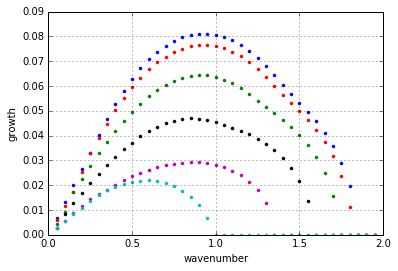

In [82]:
plt.clf
plt.plot(kk,egs_im[:,0],'.b')
plt.plot(kk,egs_im[:,2],'.r')
plt.plot(kk,egs_im[:,4],'.g')
plt.plot(kk,egs_im[:,6],'.k')
plt.plot(kk,egs_im[:,8],'.m')
plt.plot(kk,egs_im[:,10],'.c')
plt.grid('on')
#plt.title('Bump Jet')
plt.xlabel('wavenumber')
plt.ylabel('growth')
print np.max(egs_im[:,0]), np.max(egs_im[:,1])
#plt.xlim([0,2])
#plt.savefig("figure_bump.png") #
#plt.savefig("growth_Bickley.png") 

print "Profile = ", profile
print "Ny   = ", ny
print "Nz   = ", nz
plt.show()

In [ ]:
# Plot the two most unstable modes

plt.clf
plt.plot(kk,egs_im[:,0],'.b')
plt.plot(kk,egs_im[:,2],'.r')
plt.plot(kk,egs_im[:,4],'.g')
plt.plot(kk,egs_im[:,6],'.k')
plt.plot(kk,egs_im[:,8],'.m')
plt.plot(kk,egs_im[:,10],'.c')
plt.plot(kk,egs_im[:,12],'.b')
plt.plot(kk,egs_im[:,14],'.r')
plt.plot(kk,egs_im[:,16],'.g')
plt.plot(kk,egs_im[:,18],'.k')
plt.grid('on')
#plt.title('Bump Jet')
plt.xlabel('wavenumber')
plt.ylabel('growth')
print np.max(egs_im[:,0]), np.max(egs_im[:,1])
#plt.xlim([0,2])
#plt.savefig("figure_bump.png") #
#plt.savefig("growth_Bickley.png") 

print "Profile = ", profile
print "Ny   = ", ny
print "Nz   = ", nz
plt.show()

0.0811118653179 0.0
Profile =  bickley
Ny   =  50
Nz   =  50


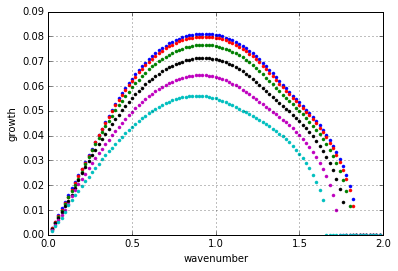

In [43]:
# Plot the two most unstable modes

plt.clf
plt.plot(kk,egs_im[:,0],'.b')
plt.plot(kk,egs_im[:,2],'.r')
plt.plot(kk,egs_im[:,4],'.g')
plt.plot(kk,egs_im[:,6],'.k')
plt.plot(kk,egs_im[:,8],'.m')
plt.plot(kk,egs_im[:,10],'.c')
plt.plot(kk,egs_im[:,12],'.b')
plt.plot(kk,egs_im[:,14],'.r')
plt.plot(kk,egs_im[:,16],'.g')
plt.plot(kk,egs_im[:,18],'.k')
plt.grid('on')
#plt.title('Bump Jet')
plt.xlabel('wavenumber')
plt.ylabel('growth')
print np.max(egs_im[:,0]), np.max(egs_im[:,1])
#plt.xlim([0,2])
#plt.savefig("figure_bump.png") #
#plt.savefig("growth_Bickley.png") 

print "Profile = ", profile
print "Ny   = ", ny
print "Nz   = ", nz
plt.show()

Max growth for curve 0 is [ 0.34699426]
Max growth for curve 1 is [ 0.09930291]


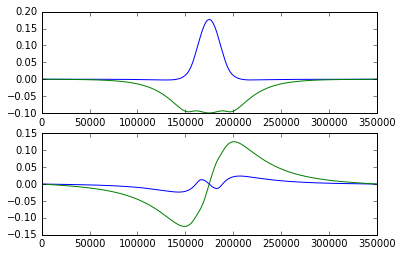

In [12]:
plt.clf()

Imax = np.zeros((2,1), dtype=int)

for ii in range(2):

    Imax[ii] = np.argmax(grow[ii,:])

    print "Max growth for curve", ii, "is", grow[ii,Imax[ii]]*3600*24
    
    plt.subplot(2,1,ii+1)
    plt.plot(y,modes[:,ii,Imax[ii]].real)
    plt.plot(y,modes[:,ii,Imax[ii]].imag)
    
plt.show()

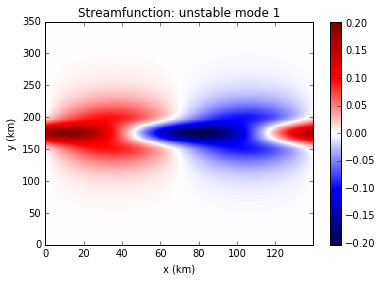

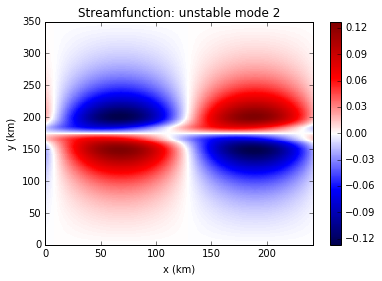

In [14]:
for ii in range(2):
    
    Lx = 2*np.pi/kk[Imax[ii]]
    x = np.linspace(0,Lx,N+1)
    xx,yy = np.meshgrid(x,y)
    
    mode2d = (np.tile(modes[:,ii,Imax[ii]],(1,N+1))*np.exp(2*np.pi*1j*xx/Lx)).real
    
    plt.clf()
    plt.pcolormesh(xx/1e3,yy/1e3,mode2d,cmap='seismic')
    plt.xlim([0, Lx/1e3])
    plt.ylim([0, L/1e3])
    plt.colorbar()
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title('Streamfunction: unstable mode '+str(ii+1))
    plt.show()    
    #plt.savefig("figure"+str(ii+3)+".png") 